# Code Imports

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

from naive_bayes_classifier import NaiveBayes

# Reading the Data

In [26]:
inflammation_data = pd.read_csv('./inflammation_diagnosis.csv', delimiter=';')

# Inspecting the Data

In [27]:
inflammation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         120 non-null    float64
 1   nausea              120 non-null    object 
 2   lumbar_pain         120 non-null    object 
 3   urine_pushing       120 non-null    object 
 4   micturition_pains   120 non-null    object 
 5   burning_of_urethra  120 non-null    object 
 6   inflammation        120 non-null    object 
 7   nephritis           120 non-null    object 
dtypes: float64(1), object(7)
memory usage: 7.6+ KB


In [28]:
inflammation_data.head()

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


# Plot the data

plot with seaborn, use different colors and sort the values by colors

In [1]:
import seaborn as sns

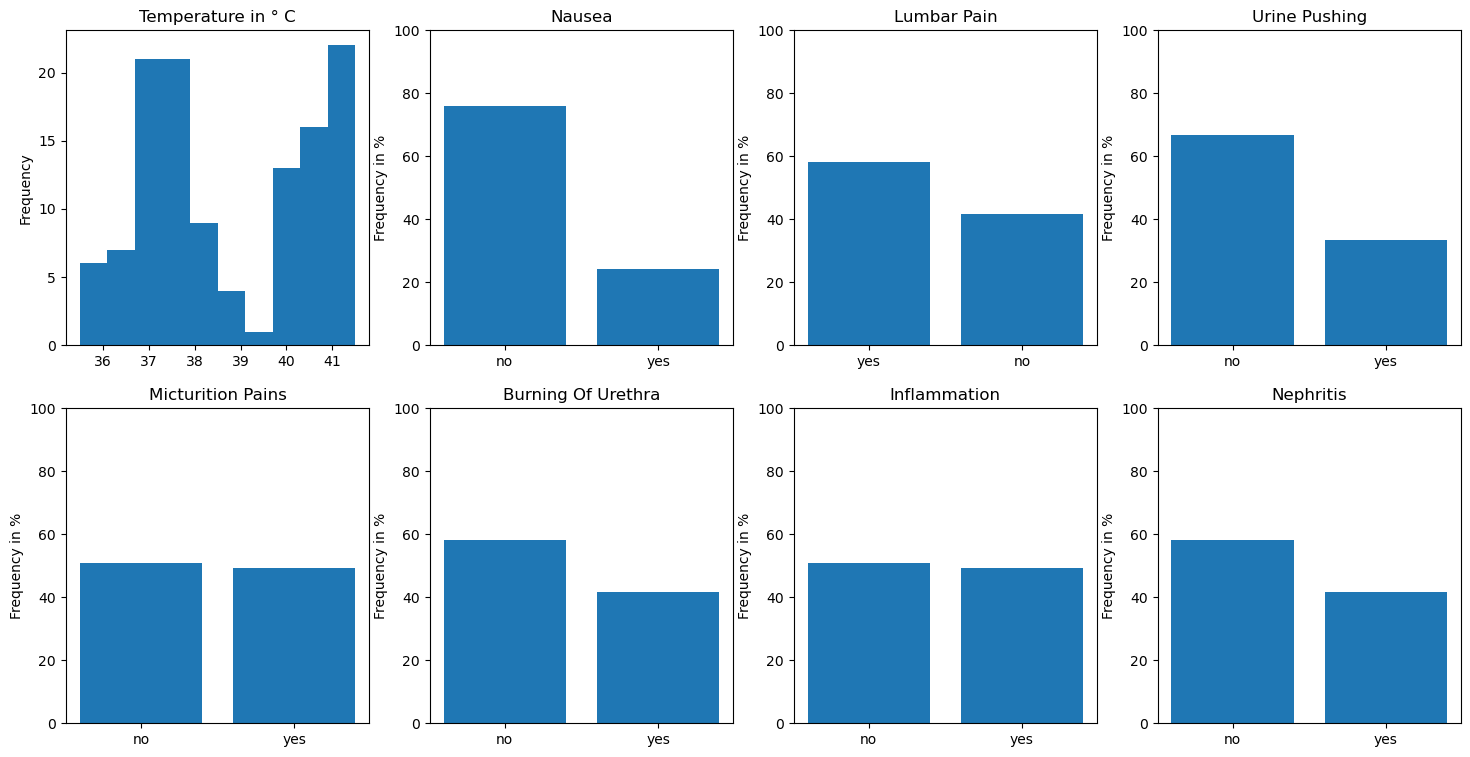

In [77]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(18,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))
        
        if inflammation_data.columns[index] == 'temperature':
            ax[row,column].hist(x=inflammation_data[inflammation_data.columns[index]])
            ax[row,column].set_title('Temperature in ° C')
            ax[row,column].set_ylabel("Frequency")
        else:
            ax[row,column].bar(inflammation_data[inflammation_data.columns[index]].unique(),inflammation_data[inflammation_data.columns[index]].value_counts().values/len(inflammation_data)*100)
            ax[row,column].set_ylabel('Frequency in %')
            ax[row,column].set_ylim(0,100)
            ax[row, column].set_title(nice_col_name)
        index += 1

# Creating Labels
## Transforming Nominal Data to Booleans

In [82]:
inflammation_data = inflammation_data.replace(to_replace='no', value=False)
inflammation_data = inflammation_data.replace(to_replace='yes', value=True)

inflammation_data

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,False,True,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False
2,35.9,False,True,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False
4,36.0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
115,41.4,False,True,True,False,True,False,True
116,41.5,False,False,False,False,False,False,False
117,41.5,True,True,False,True,False,False,True
118,41.5,False,True,True,False,True,False,True


Checking if the columns are indeed of type boolean

In [83]:
inflammation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         120 non-null    float64
 1   nausea              120 non-null    bool   
 2   lumbar_pain         120 non-null    bool   
 3   urine_pushing       120 non-null    bool   
 4   micturition_pains   120 non-null    bool   
 5   burning_of_urethra  120 non-null    bool   
 6   inflammation        120 non-null    bool   
 7   nephritis           120 non-null    bool   
dtypes: bool(7), float64(1)
memory usage: 1.9 KB


## Adding Disease Labels 
Add the disease values to a new label-column and check if the values make sense

In [84]:
inflammation_data['disease'] = [False if (inflammation_data['inflammation'][i] == False) & (inflammation_data['nephritis'][i] == False) else True for i in range(0,len(inflammation_data))]

# Splitting the Data
Count the values of 'disease' to see how the data is distributed

In [85]:
inflammation_data['disease'].value_counts(True)

disease
True     0.75
False    0.25
Name: proportion, dtype: float64

## Calculating Split Indices
The data split must account for the obvious imbalance in the data. Therefore, calculate the indices of the splits.

### Calculate Absolute Fractions
First, calculate how many rows go to the train and test set respectively.

In [86]:
# constants
DATASET_LENGTH = len(inflammation_data) # 120

# splits must add up to 1.0
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2

# variables
train_absolute = DATASET_LENGTH * TRAIN_SPLIT # 96
test_absolute = DATASET_LENGTH * TEST_SPLIT # 24

### Calculate Relative Indices
Next, calculate the absolute fraction of True and False values per dataset.

In [87]:
fraction_true, fraction_false = inflammation_data['disease'].value_counts(True) # 0.75, 0.25

train_true = int(train_absolute * fraction_true) # 72
train_false = int(train_absolute * fraction_false) # 24

72 of the 96 truthy values of the inflammation dataset go into the training-set, the rest goes to the test-set.

Lastly, using the fractional indices, assign the stratified split to the respective dataframes.

In [88]:
# save the splits into these two empty dataframes
train = pd.DataFrame(columns=inflammation_data.columns)
test = pd.DataFrame(columns=inflammation_data.columns)

# group all True and False values together
inflammation_grouped = inflammation_data.groupby(by='disease')

# Use the fractional indices to assign the stratified split to the respective dataframes
train = pd.concat(objs=[train, inflammation_grouped.get_group(True).iloc[: train_true, :]])
train = pd.concat(objs=[train, inflammation_grouped.get_group(False).iloc[: train_false, :]])

test = pd.concat(objs=[test, inflammation_grouped.get_group(True).iloc[train_true :, :]])
test = pd.concat(objs=[test, inflammation_grouped.get_group(False).iloc[train_false :, :]])

## Ensuring that the two dataframes do not share a column
The following merge shows duplicate rows across the two dataframes. If empty, there are no duplicates.

In [89]:
result = train.merge(right=test, how='inner', indicator=False)
result

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis,disease


[1, 1, 1, 1]